Обучается модель на основе MobileNet. Как объясняется в ноутбуке dataset_prep, для каждой пары вычисляется исходное и закрытое латентные расстояния. Модель обучается предсказывать разность этих расстояний на основе только закрытой фотограии, имитируя ситуацию перед банкоматом: известна только закрытая фотография человека, модель не знает, как выглядит его фотография в базе данных и как он бы выглядел без закрытия. Модель удалось обучить на протяжении 9 эпох на обучающем датасете размером в 600000 фотографий (всего в датасете 31600 пар и 24 закрытия, train-val-test деление в соотношении 80-10-10).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/Faces/LFWcropObstr

Суммарное число фотографий в датасете:

In [3]:
!unzip /content/gdrive/My\ Drive/Colab\ Notebooks/Faces/LFWcropObstr/LFWcropObstr24_.zip | wc -l

758404


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import math
import scipy.stats as scs
import itertools
import pickle
from sklearn.metrics import roc_curve, f1_score, roc_auc_score, classification_report, r2_score
from sklearn import model_selection
import logging
import itertools
from matplotlib import pyplot as plt 
from PIL import Image
%matplotlib inline

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/Faces/LFWcropObstr

In [7]:
PATH = "/content/gdrive/My Drive/Colab Notebooks/Faces/LFWcropObstr"

In [8]:
train_df = pd.read_csv(PATH + '/' + 'LFWcropObstr24_train.csv')
train_df = train_df.sample(len(train_df))
train_df['label'] = train_df['augmented'] - train_df['initial']
train_df.drop(['augmented', 'initial'], axis=1, inplace=True)
print(train_df.shape)
train_df.head()

(606787, 2)


,img,label
2949,LFWcropObstr_train/IdentityIdentityIdentity367...,0.000000
403757,LFWcropObstr_train/EyepatchWhiteMaskHood30504....,0.190300
573913,LFWcropObstr_train/SunglassesWhiteMaskIdentity...,0.076067
500920,LFWcropObstr_train/SunglassesBlackMaskHood2580...,0.295472
201624,LFWcropObstr_train/IdentityWhiteMaskHood30651....,0.196599


In [9]:
val_df = pd.read_csv(PATH + '/' + 'LFWcropObstr24_val.csv')
val_df = val_df.sample(len(val_df))
val_df['label'] = val_df['augmented'] - val_df['initial']
val_df.drop(['augmented', 'initial'], axis=1, inplace=True)
print(val_df.shape)
val_df.head()

(75814, 2)


,img,label
38693,LFWcropObstr_val/EyepatchScarfIdentity6818.jpeg,0.016463
10394,LFWcropObstr_val/IdentityBlackMaskHood9560.jpeg,0.013641
1528,LFWcropObstr_val/IdentityIdentityIdentity15502...,0.000000
34308,LFWcropObstr_val/EyepatchBlackMaskIdentity2655...,-0.021667
18803,LFWcropObstr_val/IdentityScarfHood31134.jpeg,0.195249


In [10]:
def dataGenerator(df, train):
    if train:
        for idx, line in df.iterrows():
            image, label = line['img'], line['label']
            image = tf.image.resize(tf.image.decode_image(tf.io.read_file(image)), [224, 224])
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, 0.1)
            image = tf.image.random_saturation(image, 0.9, 1.1)
            image = tf.image.random_contrast(image, 0.9, 1.1)
            image = tf.minimum(image, 255.0)
            image = tf.maximum(image, 0.0)
            yield (image / 255.0, tf.cast(label, tf.float32))
    else:
        for idx, line in df.iterrows():
            image, label = line['img'], line['label']
            image = tf.image.resize(tf.image.decode_image(tf.io.read_file(image)), [224, 224])
            yield (image / 255.0, tf.cast(label, tf.float32))

Демонстрация обучающих примеров: над фотографией выводится ее метка (разность расстояний).

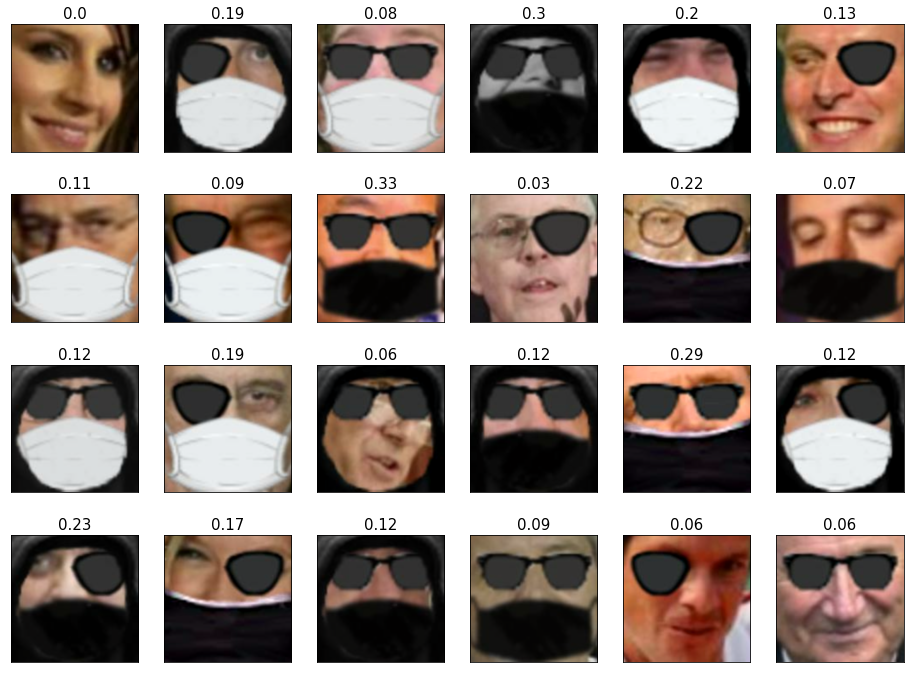

In [18]:
ds = tf.data.Dataset.from_generator(lambda: dataGenerator(train_df, True), (tf.float32, tf.float32)).batch(24)
fig = plt.figure(figsize=(16, 12))
example = next(iter(ds))
for i, (img, label) in enumerate(zip(*example)):
    ax = fig.add_subplot(4, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(str(np.round(float(label), 2)), fontsize=15)
plt.savefig(PATH + '/presentation/traindata_demo.pdf', format='pdf')

In [ ]:
def train_ds_gen():
    yield from tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255.,
        brightness_range=(0.9, 1.1),
        horizontal_flip=True,
        vertical_flip=False
    ).flow_from_dataframe(
        train_df, directory='.', x_col='img', y_col='label', target_size=(224, 224), 
        color_mode='rgb',
        class_mode='raw', batch_size=32, shuffle=True, seed=None,
        subset=None
    )
def val_ds_gen():
    yield from tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255.,
        brightness_range=(1, 1),
        horizontal_flip=False,
        vertical_flip=False
    ).flow_from_dataframe(
        val_df, directory='.', x_col='img', y_col='label', target_size=(224, 224), 
        color_mode='rgb',
        class_mode='raw', batch_size=32, shuffle=True, seed=None,
        subset=None
    )

In [ ]:
train_ds = tf.data.Dataset.from_generator(train_ds_gen, output_types=(tf.float32, tf.float32), 
                                          output_shapes=((32, 224, 224, 3), (32,)))
train_ds = train_ds.map(lambda img, label: (tf.convert_to_tensor(img, tf.float32), label))
train_ds = train_ds.take(train_df.shape[0] // 32)

In [ ]:
val_ds = tf.data.Dataset.from_generator(val_ds_gen, output_types=(tf.float32, tf.float32),
                                        output_shapes=((32, 224, 224, 3), (32,)))
val_ds = val_ds.map(lambda img, label: (tf.convert_to_tensor(img, tf.float32), label))
val_ds = val_ds.take(val_df.shape[0] // 32)

In [ ]:
model = tf.keras.applications.mobilenet.MobileNet(alpha=1, input_shape=(224, 224, 3), weights='imagenet', include_top=False)
inp = tf.keras.Input((224, 224, 3))
model = model(inp)
model = tf.keras.layers.AveragePooling2D((7, 7))(model)
model = tf.keras.layers.Reshape((1024, ))(model)
model = tf.keras.layers.Dense(1)(model)
model = tf.keras.Model(inputs=inp, outputs=model)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 1024)        0         
_________________________________________________________________
reshape (Reshape)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 3,208,001
Non-trainable params: 21,888
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
loss = tf.keras.losses.MSE

model.compile(optimizer=optimizer, loss=loss)

In [ ]:
for i in range(5):
    history = model.fit(train_ds, validation_data=val_ds, epochs=2, callbacks=[scheduler])
    model.save(PATH + '/' + 'MobileNet1_{}epoch_24cl.h5'.format(2+i*2), overwrite=True, include_optimizer=True, save_format='h5')

In [ ]:
model = tf.keras.models.load_model(PATH + '/' + 'MobileNet1_2epoch_24cl.h5')

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
loss = tf.keras.losses.MSE

model.compile(optimizer=optimizer, loss=loss)

In [ ]:
for i in range(1, 5):
    history = model.fit(train_ds, validation_data=val_ds, epochs=2, callbacks=[scheduler])
    model.save(PATH + '/' + 'MobileNet1_{}epoch_24cl.h5'.format(2+i*2), overwrite=True, include_optimizer=True, save_format='h5')

In [ ]:
model = tf.keras.models.load_model(PATH + '/' + 'MobileNet1_4epoch_24cl.h5')

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
loss = tf.keras.losses.MSE

model.compile(optimizer=optimizer, loss=loss)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=2, callbacks=[scheduler])
model.save(PATH + '/' + 'MobileNet1_6epoch_24cl.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [ ]:
model = tf.keras.models.load_model(PATH + '/' + 'MobileNet1_6epoch_24cl.h5')

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
loss = tf.keras.losses.MSE

model.compile(optimizer=optimizer, loss=loss)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=2, callbacks=[scheduler])
model.save(PATH + '/' + 'MobileNet1_8epoch_24cl.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0002)
scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
loss = tf.keras.losses.MSE

model.compile(optimizer=optimizer, loss=loss)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=1, callbacks=[scheduler])
model.save(PATH + '/' + 'MobileNet1_8epoch_24cl.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=1, callbacks=[scheduler])
model.save(PATH + '/' + 'MobileNet1_9epoch_24cl.h5', overwrite=True, include_optimizer=True, save_format='h5')